In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# Check TensorFlow version and GPU availability
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU is {'available' if tf.config.list_physical_devices('GPU') else 'NOT AVAILABLE'}")


TensorFlow version: 2.14.0
GPU is NOT AVAILABLE


In [5]:
data_dir = './parkinsons_dataset'

IMG_SIZE = 224 
BATCH_SIZE = 32


In [6]:
# Load and preprocess the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # Using 20% of the data for validation
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

# Only rescaling for validation
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Assuming binary classification
    subset='training',
    shuffle=True
)

# Validation data generator
valid_generator = valid_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

class_indices = train_generator.class_indices
print("Class indices:", class_indices)


Found 665 images belonging to 2 classes.
Found 166 images belonging to 2 classes.
Class indices: {'normal': 0, 'parkinson': 1}


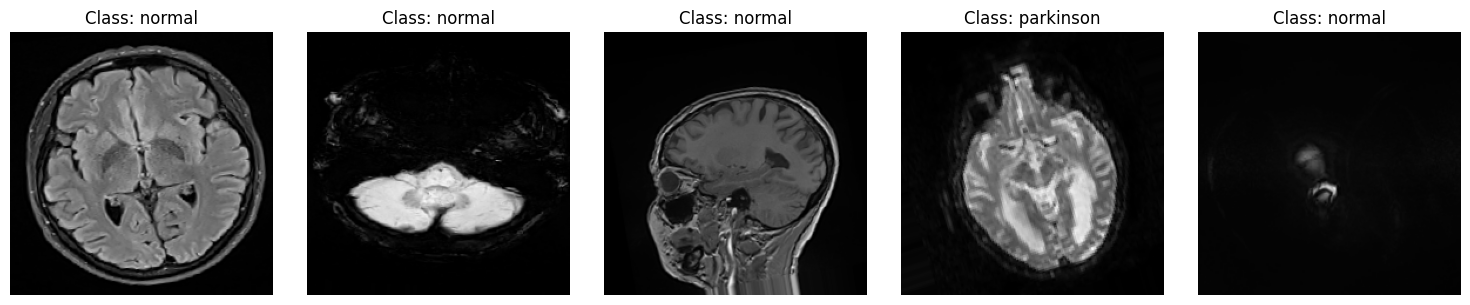

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Retrieve a single batch of augmented images and labels
augmented_images, augmented_labels = next(train_generator)

# Get the class labels
class_labels = list(train_generator.class_indices.keys())

# Number of augmented images to display
num_samples = 5

# Create a figure to display the images
plt.figure(figsize=(15, 3))

for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    image = augmented_images[i]
    label = augmented_labels[i]
    
    # Handle grayscale images if necessary
    if image.shape[-1] == 1:
        plt.imshow(image.squeeze(), cmap='gray')
    else:
        plt.imshow(image)
    
    # Retrieve the class name
    class_name = class_labels[int(label)]
    
    plt.title(f"Class: {class_name}")
    plt.axis('off')  # Hide the axis

plt.tight_layout()
plt.show()


In [15]:
# Define the Squash function used in Capsule Networks
def squash(vectors, axis=-1):
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm)
    return scale * vectors / tf.sqrt(s_squared_norm + keras.backend.epsilon())


In [48]:
# Define custom Capsule Network layers
class PrimaryCapsule(layers.Layer):
    def __init__(self, dim_capsule, n_channels, kernel_size, strides, padding, **kwargs):
        super(PrimaryCapsule, self).__init__(**kwargs)
        self.dim_capsule = dim_capsule
        self.n_channels = n_channels
        self.conv = layers.Conv1D(filters=dim_capsule * n_channels,
                                  kernel_size=kernel_size,
                                  strides=strides,
                                  padding=padding,
                                  name='primarycap_conv1d')

    def call(self, inputs):
        outputs = self.conv(inputs)
        outputs = layers.Reshape(target_shape=[-1, self.dim_capsule])(outputs)
        outputs = squash(outputs)
        return outputs  # [batch_size, num_capsules, dim_capsule]

class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3,
                 kernel_initializer='he_normal', **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule  # Number of output capsules
        self.dim_capsule = dim_capsule  # Dimension of each output capsule
        self.routings = routings
        self.kernel_initializer = keras.initializers.get(kernel_initializer)

    def build(self, input_shape):
        # input_shape: [batch_size, input_num_capsule, input_dim_capsule]
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(
            shape=[self.input_num_capsule, self.num_capsule, self.input_dim_capsule, self.dim_capsule],
            initializer=self.kernel_initializer,
            name='W'
        )

        super(CapsuleLayer, self).build(input_shape)

    def call(self, inputs):
        # inputs shape: [batch_size, input_num_capsule, input_dim_capsule]
        # Expand dims to match W's dimensions
        inputs_expand = tf.expand_dims(inputs, 2)  # [batch_size, input_num_capsule, 1, input_dim_capsule]
        inputs_expand = tf.tile(inputs_expand, [1, 1, self.num_capsule, 1])  # [batch_size, input_num_capsule, num_capsule, input_dim_capsule]

        # Compute u_hat
        u_hat = tf.einsum('bijc,ijkc->bijk', inputs_expand, self.W)  # [batch_size, input_num_capsule, num_capsule, dim_capsule]

        # Routing algorithm
        b = tf.zeros(shape=[tf.shape(inputs)[0], self.input_num_capsule, self.num_capsule])

        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=-1)
            c = tf.expand_dims(c, -1)
            s = tf.reduce_sum(c * u_hat, axis=1)
            v = squash(s)
            if i < self.routings - 1:
                v_tiled = tf.expand_dims(v, 1)
                b += tf.reduce_sum(u_hat * v_tiled, axis=-1)
        return v  # [batch_size, num_capsule, dim_capsule]

class Length(layers.Layer):
    def call(self, inputs, **kwargs):
        return tf.sqrt(tf.reduce_sum(tf.square(inputs), -1) + keras.backend.epsilon())


In [49]:
# Build the Vision Transformer model
def create_vit_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Data augmentation
    augmented = layers.RandomFlip("horizontal")(inputs)
    augmented = layers.RandomRotation(0.1)(augmented)
    augmented = layers.RandomZoom(0.1)(augmented)

    # Create patches
    patch_size = 16
    num_patches = (IMG_SIZE // patch_size) ** 2
    projection_dim = 64
    num_heads = 4
    transformer_units = [projection_dim * 2, projection_dim]
    transformer_layers = 8

    # Patch embedding
    patches = layers.Conv2D(filters=projection_dim,
                            kernel_size=patch_size,
                            strides=patch_size,
                            padding='VALID')(augmented)
    patches = layers.Reshape((num_patches, projection_dim))(patches)

    # Positional embedding
    positions = tf.range(start=0, limit=num_patches, delta=1)
    positional_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)
    encoded_patches = patches + positional_embedding

    # Transformer blocks
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Multi-head attention layer
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = layers.Dense(transformer_units[0], activation=tf.nn.gelu)(x3)
        x3 = layers.Dense(transformer_units[1], activation=tf.nn.gelu)(x3)
        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Flatten the patches
    flattened_patches = layers.Flatten()(encoded_patches)
    vit_output = layers.Dense(128, activation='relu')(flattened_patches)
    vit_output = layers.Reshape((-1, 16))(vit_output)  # Adjusted for Capsule Network

    return inputs, vit_output


In [68]:
def create_capsule_network(vit_output):
    # Flatten vit_output
    vit_flattened = layers.Flatten()(vit_output)  # Shape: [batch_size, -1]

    # Adjust dimension to match capsule requirements
    vit_dense = layers.Dense(256 * 16, activation='relu')(vit_flattened)

    # Reshape to [batch_size, input_num_capsule, input_dim_capsule]
    vit_reshaped = layers.Reshape((256, 16))(vit_dense)  # Shape: [batch_size, 256, 16]

    # Capsule Layer
    digit_caps = CapsuleLayer(num_capsule=2, dim_capsule=16, routings=3, name='digit_caps')(vit_reshaped)

    # Flatten the output of digit_caps
    x = layers.Flatten()(digit_caps)  # Shape: [batch_size, 2 * 16] => [batch_size, 32]

    # Output layer
    outputs = layers.Dense(1, activation='sigmoid', name='output')(x)  # Shape: [batch_size, 1]

    return outputs


In [69]:
# Combine ViT and Capsule Network into one model
input_shape = (IMG_SIZE, IMG_SIZE, 3)
inputs, vit_output = create_vit_model(input_shape)
capsnet_output = create_capsule_network(vit_output)

model = keras.Model(inputs=inputs, outputs=capsnet_output)
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 random_flip_10 (RandomFlip  (None, 224, 224, 3)          0         ['input_11[0][0]']            
 )                                                                                                
                                                                                                  
 random_rotation_10 (Random  (None, 224, 224, 3)          0         ['random_flip_10[0][0]']      
 Rotation)                                                                                        
                                                                                            

In [70]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


# Train the model
epochs = 50

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 0.5862 - accuracy: 0.7218
Epoch 1: val_accuracy did not improve from 0.73494
21/21 [==============================] - 56s 2s/step - loss: 0.5862 - accuracy: 0.7218 - val_loss: 0.5841 - val_accuracy: 0.7349 - lr: 1.0000e-04
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 0.5846 - accuracy: 0.7338
Epoch 2: val_accuracy did not improve from 0.73494
21/21 [==============================] - 42s 2s/step - loss: 0.5846 - accuracy: 0.7338 - val_loss: 0.5794 - val_accuracy: 0.7349 - lr: 1.0000e-04
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.5814 - accuracy: 0.7338
Epoch 3: val_accuracy did not improve from 0.73494
21/21 [==============================] - 42s 2s/step - loss: 0.5814 - accuracy: 0.7338 - val_loss: 0.5747 - val_accuracy: 0.7349 - lr: 1.0000e-04
Epoch 4/50
21/21 [==============================] - ETA: 0s - loss: 0.5736 - accuracy: 0.7338
Epoch 4: val_accuracy did not imp

C:\Users\VARUN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 47s 2s/step - loss: 0.3897 - accuracy: 0.8391 - val_loss: 0.3327 - val_accuracy: 0.8554 - lr: 1.0000e-04
Epoch 10/50
21/21 [==============================] - ETA: 0s - loss: 0.3899 - accuracy: 0.8391
Epoch 10: val_accuracy did not improve from 0.85542
21/21 [==============================] - 54s 3s/step - loss: 0.3899 - accuracy: 0.8391 - val_loss: 0.4092 - val_accuracy: 0.7892 - lr: 1.0000e-04
Epoch 11/50
21/21 [==============================] - ETA: 0s - loss: 0.3287 - accuracy: 0.8842
Epoch 11: val_accuracy improved from 0.85542 to 0.92771, saving model to parkinsons_vit_capsnet.h5
21/21 [==============================] - 47s 2s/step - loss: 0.3287 - accuracy: 0.8842 - val_loss: 0.2657 - val_accuracy: 0.9277 - lr: 1.0000e-04
Epoch 12/50
21/21 [==============================] - ETA: 0s - loss: 0.3217 - accuracy: 0.8902
Epoch 12: val_accuracy improved from 0.92771 to 0.95181, saving model to parkinsons_vit_capsnet.h5
21/21 [====================

In [71]:
# Ensure you're using the best model weights
model.load_weights('parkinsons_vit_capsnet.h5')

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(valid_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


6/6 [==============================] - 3s 494ms/step - loss: 0.1758 - accuracy: 0.9819
Validation Loss: 0.1758
Validation Accuracy: 0.9819


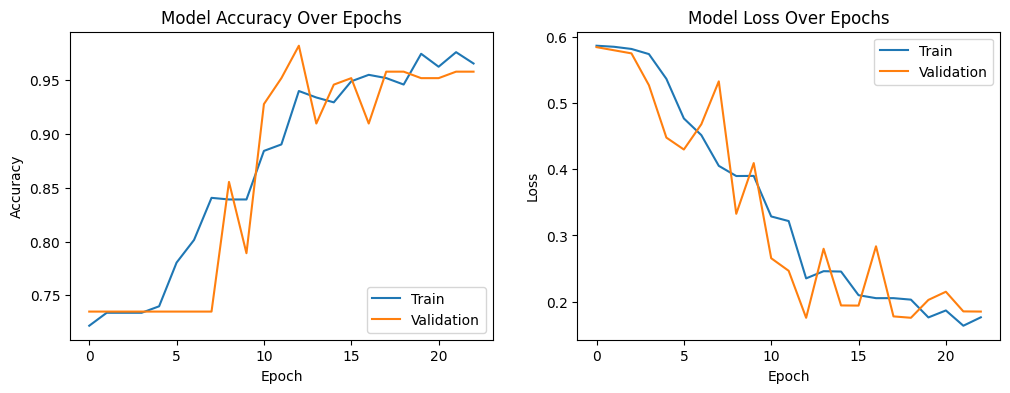

In [76]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()


In [63]:
# Inspect class distribution
print(f"Class Indices: {class_indices}")
print(f"Number of samples in validation set: {len(y_true)}")
unique, counts = np.unique(y_true, return_counts=True)
print(f"Class distribution in validation set: {dict(zip(unique, counts))}")


Class Indices: {'normal': 0, 'parkinson': 1}
Number of samples in validation set: 166
Class distribution in validation set: {0: 122, 1: 44}


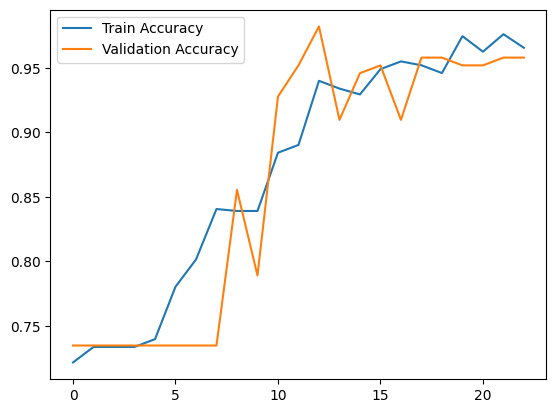

In [77]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


In [78]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = valid_generator.classes
y_pred_prob = model.predict(valid_generator)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))


6/6 [==============================] - 3s 509ms/step
[[122   0]
 [  3  41]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       122
           1       1.00      0.93      0.96        44

    accuracy                           0.98       166
   macro avg       0.99      0.97      0.98       166
weighted avg       0.98      0.98      0.98       166



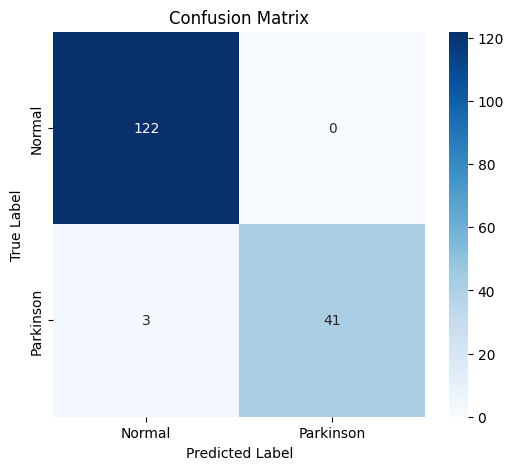

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the confusion matrix data
confusion_matrix = np.array([[122, 0], [3, 41]])
class_names = ["Normal", "Parkinson"]

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from sklearn.model_selection import train_test_split

# Define paths
data_dir = './parkinsons_dataset'  # Replace with your actual path
categories = ['normal', 'parkinson']
image_size = 256  # Resized image size

# Function to load and preprocess images
def load_images(data_dir, categories, image_size):
    images = []
    labels = []
    for label, category in enumerate(categories):
        category_dir = os.path.join(data_dir, category)
        for img_name in os.listdir(category_dir):
            img_path = os.path.join(category_dir, img_name)
            try:
                img = io.imread(img_path, as_gray=True)  # Load as grayscale
                img = transform.resize(img, (image_size, image_size), anti_aliasing=True)
                img = img.astype('float32')
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Load images and labels
images, labels = load_images(data_dir, categories, image_size)
print(f"Total images: {images.shape[0]}")
print(f"Image shape: {images.shape[1:]}")


Total images: 831
Image shape: (256, 256)


In [14]:
# Min-Max Normalization
def min_max_normalize(images):
    Vmin = images.min()
    Vmax = images.max()
    normalized_images = (images - Vmin) / (Vmax - Vmin)
    return normalized_images

images_normalized = min_max_normalize(images)


In [23]:
import pywt
from skimage.feature import graycomatrix, graycoprops
def apply_swt(image, level=3, wavelet='coif1'):
    coeffs = pywt.swt2(image, wavelet, level=level)
    return coeffs

def extract_glcm_features(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True):
    image_scaled = (image * (levels - 1)).astype('uint8')
    glcm = graycomatrix(image_scaled, 
                        distances=distances, 
                        angles=angles, 
                        levels=levels, 
                        symmetric=symmetric, 
                        normed=normed)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return [contrast, energy, homogeneity, correlation]

def extract_hybrid_features(image, level=3, wavelet='coif1'):
    coeffs = apply_swt(image, level, wavelet)
    features = []
    
    for idx, (cA, (cH, cV, cD)) in enumerate(coeffs):
        # GLCM features from Approximation Coefficients
        glcm_feats_cA = extract_glcm_features(cA)
        features.extend(glcm_feats_cA)
        
        # GLCM features from Detail Coefficients
        glcm_feats_cH = extract_glcm_features(cH)
        glcm_feats_cV = extract_glcm_features(cV)
        glcm_feats_cD = extract_glcm_features(cD)
        features.extend(glcm_feats_cH)
        features.extend(glcm_feats_cV)
        features.extend(glcm_feats_cD)
    
    # Truncate or pad to get 13 features
    if len(features) > 13:
        features = features[:13]
    elif len(features) < 13:
        features += [0] * (13 - len(features))
    
    return features

# Extract hybrid features for all images
hybrid_features = []
for img in images_normalized:
    feats = extract_hybrid_features(img)
    hybrid_features.append(feats)

hybrid_features = np.array(hybrid_features)
print(f"Hybrid Features Shape: {hybrid_features.shape}")  # Expected: (num_images, 13)


Hybrid Features Shape: (831, 13)


In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
hybrid_features_scaled = scaler.fit_transform(hybrid_features)


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    hybrid_features_scaled, 
    labels, 
    test_size=0.2, 
    random_state=42, 
    stratify=labels
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")


Training samples: 664
Validation samples: 167


In [27]:
# Convert labels to categorical if using 2 output neurons
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)

# Define the ANN model
def create_ann_model(input_dim, hidden_neurons=10):
    model = Sequential()
    model.add(Dense(hidden_neurons, input_dim=input_dim, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model

model_ann = create_ann_model(input_dim=hybrid_features_scaled.shape[1], hidden_neurons=10)
model_ann.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10)                140       
                                                                 
 dense_3 (Dense)             (None, 2)                 22        
                                                                 
Total params: 162 (648.00 Byte)
Trainable params: 162 (648.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
model_ann.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [29]:
# Define callbacks
checkpoint_ann = ModelCheckpoint(
    'parkinsons_ann.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop_ann = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_ann = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)


In [30]:
# Train the ANN model
epochs = 50

history_ann = model_ann.fit(
    X_train,
    y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=epochs,
    callbacks=[checkpoint_ann, early_stop_ann, reduce_lr_ann],
    batch_size=32,
    verbose=1
)


Epoch 1/50
 1/21 [>.............................] - ETA: 8s - loss: 0.7129 - accuracy: 0.4375
Epoch 1: val_accuracy improved from -inf to 0.69461, saving model to parkinsons_ann.h5
21/21 [==============================] - 1s 10ms/step - loss: 0.7070 - accuracy: 0.4458 - val_loss: 0.6732 - val_accuracy: 0.6946 - lr: 0.0010
Epoch 2/50
17/21 [=======================>......] - ETA: 0s - loss: 0.6539 - accuracy: 0.7426
Epoch 2: val_accuracy improved from 0.69461 to 0.74251, saving model to parkinsons_ann.h5
21/21 [==============================] - 0s 5ms/step - loss: 0.6495 - accuracy: 0.7470 - val_loss: 0.6292 - val_accuracy: 0.7425 - lr: 0.0010
Epoch 3/50
 1/21 [>.............................] - ETA: 0s - loss: 0.6360 - accuracy: 0.7188
Epoch 3: val_accuracy did not improve from 0.74251
21/21 [==============================] - 0s 2ms/step - loss: 0.6148 - accuracy: 0.7364 - val_loss: 0.6038 - val_accuracy: 0.7365 - lr: 0.0010
Epoch 4/50
 1/21 [>.............................] - ETA: 0s - l

C:\Users\VARUN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 4: val_accuracy did not improve from 0.74251
21/21 [==============================] - 0s 3ms/step - loss: 0.5946 - accuracy: 0.7334 - val_loss: 0.5885 - val_accuracy: 0.7365 - lr: 0.0010
Epoch 5/50
 1/21 [>.............................] - ETA: 0s - loss: 0.7173 - accuracy: 0.5625
Epoch 5: val_accuracy did not improve from 0.74251
21/21 [==============================] - 0s 2ms/step - loss: 0.5822 - accuracy: 0.7334 - val_loss: 0.5790 - val_accuracy: 0.7365 - lr: 0.0010
Epoch 6/50
 1/21 [>.............................] - ETA: 0s - loss: 0.6594 - accuracy: 0.6250
Epoch 6: val_accuracy did not improve from 0.74251
21/21 [==============================] - 0s 3ms/step - loss: 0.5751 - accuracy: 0.7334 - val_loss: 0.5735 - val_accuracy: 0.7365 - lr: 0.0010
Epoch 7/50
 1/21 [>.............................] - ETA: 0s - loss: 0.5680 - accuracy: 0.7188
Epoch 7: val_accuracy did not improve from 0.74251
21/21 [==============================] - 0s 2ms/step - loss: 0.5707 - accuracy: 0.7334 

In [31]:
# Load the best model weights
model_ann.load_weights('parkinsons_ann.h5')


In [32]:
# Evaluate on the validation set
loss_ann, accuracy_ann = model_ann.evaluate(X_val, y_val_cat)
print(f"ANN Validation Loss: {loss_ann:.4f}")
print(f"ANN Validation Accuracy: {accuracy_ann:.4f}")


6/6 [==============================] - 0s 3ms/step - loss: 0.3815 - accuracy: 0.8443
ANN Validation Loss: 0.3815
ANN Validation Accuracy: 0.8443


In [33]:
from sklearn.metrics import confusion_matrix, classification_report

# Predictions
y_pred_prob_ann = model_ann.predict(X_val)
y_pred_ann = np.argmax(y_pred_prob_ann, axis=1)

# Confusion Matrix
cm_ann = confusion_matrix(y_val, y_pred_ann)
print("Confusion Matrix:\n", cm_ann)

# Classification Report
report_ann = classification_report(y_val, y_pred_ann, target_names=categories)
print("Classification Report:\n", report_ann)


6/6 [==============================] - 0s 1ms/step
Confusion Matrix:
 [[123   0]
 [ 26  18]]
Classification Report:
               precision    recall  f1-score   support

      normal       0.83      1.00      0.90       123
   parkinson       1.00      0.41      0.58        44

    accuracy                           0.84       167
   macro avg       0.91      0.70      0.74       167
weighted avg       0.87      0.84      0.82       167



In [36]:
# Lists to store the metrics
loss = [
    0.5862, 0.5846, 0.5814, 0.5736, 0.5363,
    0.4765, 0.4514, 0.4050, 0.3897, 0.3899,
    0.3287, 0.3217, 0.2353, 0.2456, 0.2054,
    0.2054, 0.1638, 0.1765, 0.1764, 0.1869,
    0.1638, 0.1765
]

accuracy = [
    0.7218, 0.7338, 0.7338, 0.7338, 0.7398,
    0.7805, 0.8015, 0.8406, 0.8391, 0.8391,
    0.8902, 0.8902, 0.9398, 0.9293, 0.9549,
    0.9519, 0.9759, 0.9654, 0.9744, 0.9624,
    0.9759, 0.9654
]

val_loss = [
    0.5841, 0.5794, 0.5747, 0.5267, 0.4476,
    0.4297, 0.4677, 0.5325, 0.3327, 0.4092,
    0.2657, 0.2467, 0.1758, 0.1944, 0.1942,
    0.2837, 0.1854, 0.1852, 0.2028, 0.2151,
    0.1854, 0.1852
]

val_accuracy = [
    0.7349, 0.7349, 0.7349, 0.7349, 0.7349,
    0.7349, 0.7349, 0.7349, 0.8554, 0.7892,
    0.9277, 0.9518, 0.9819, 0.9458, 0.9578,
    0.9578, 0.9578, 0.9578, 0.9518, 0.9518,
    0.9578, 0.9578
]

learning_rate = [
    1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04,
    1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04,
    1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04,
    2.0000e-05, 2.0000e-05, 2.0000e-05, 2.0000e-05, 2.0000e-05,
    2.0000e-05, 3.999999898951501e-06
]


In [37]:
print(len(loss), len(accuracy), len(val_loss), len(val_accuracy), len(learning_rate))
# Output: 23 23 23 23 23


22 22 22 22 22


In [38]:
history = {
    'loss': loss,
    'accuracy': accuracy,
    'val_loss': val_loss,
    'val_accuracy': val_accuracy,
    'lr': learning_rate
}


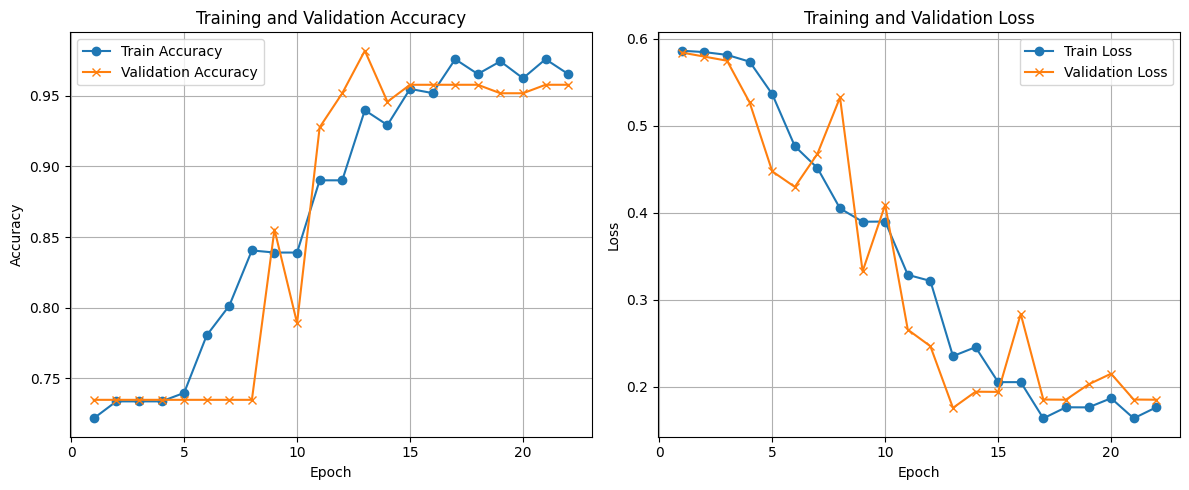

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, 23), history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(range(1, 23), history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, 23), history['loss'], label='Train Loss', marker='o')
plt.plot(range(1, 23), history['val_loss'], label='Validation Loss', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


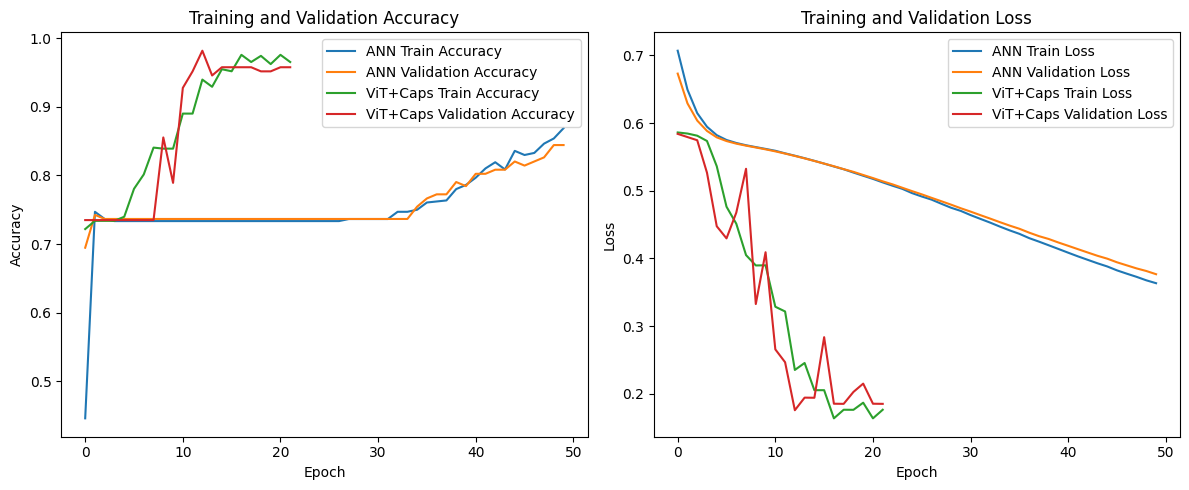

In [42]:
# Plotting Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_ann.history['accuracy'], label='ANN Train Accuracy')
plt.plot(history_ann.history['val_accuracy'], label='ANN Validation Accuracy')
plt.plot(history['accuracy'], label='ViT+Caps Train Accuracy')
plt.plot(history['val_accuracy'], label='ViT+Caps Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history_ann.history['loss'], label='ANN Train Loss')
plt.plot(history_ann.history['val_loss'], label='ANN Validation Loss')
plt.plot(history['loss'], label='ViT+Caps Train Loss')
plt.plot(history['val_loss'], label='ViT+Caps Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


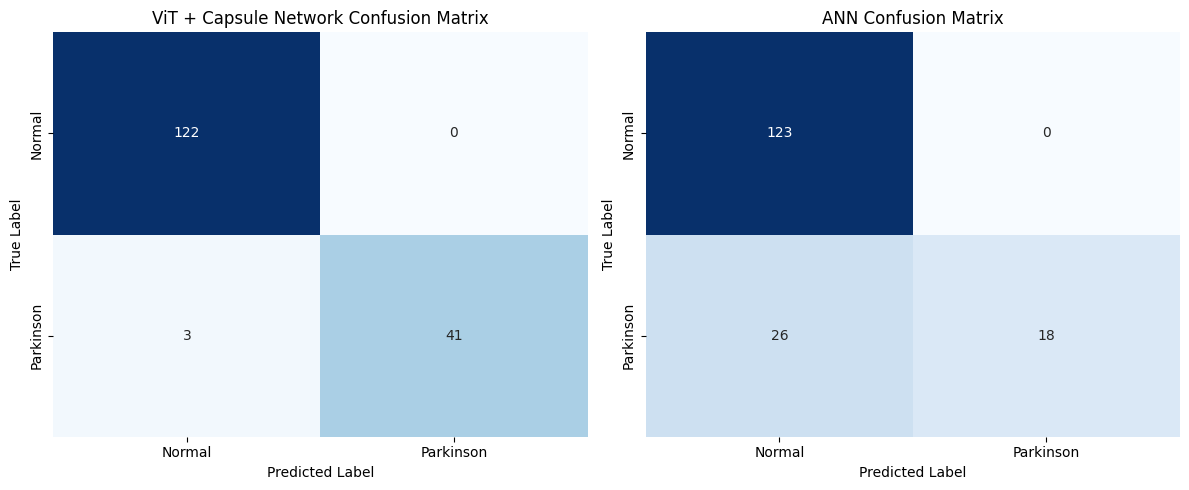

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the confusion matrices
cm_vit_caps = np.array([[122, 0],
                        [3, 41]])

cm_ann = np.array([[123, 0],
                   [26, 18]])

# Define class labels
class_names = ['Normal', 'Parkinson']

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot confusion matrix for ViT + Capsule Network model
sns.heatmap(cm_vit_caps, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=class_names, yticklabels=class_names, cbar=False)
axes[0].set_title('ViT + Capsule Network Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Plot confusion matrix for ANN model
sns.heatmap(cm_ann, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=class_names, yticklabels=class_names, cbar=False)
axes[1].set_title('ANN Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


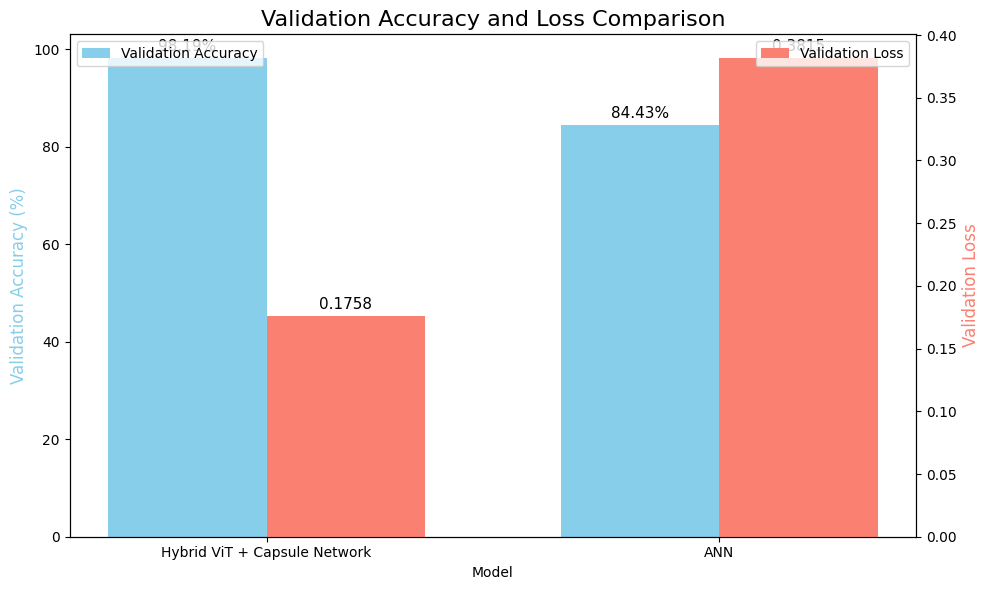

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Hybrid ViT + Capsule Network', 'ANN']
accuracy = [98.19, 84.43]
loss = [0.1758, 0.3815]

# Create subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Define bar width
bar_width = 0.35

# Set positions of the bars on the x-axis
index = np.arange(len(models))

# Plot Validation Accuracy
bars1 = ax1.bar(index, accuracy, bar_width, label='Validation Accuracy', color='skyblue')

# Create a twin axis to plot Validation Loss
ax2 = ax1.twinx()

# Plot Validation Loss
bars2 = ax2.bar(index + bar_width, loss, bar_width, label='Validation Loss', color='salmon')

# Labels and Titles
ax1.set_xlabel('Model')
ax1.set_ylabel('Validation Accuracy (%)', color='skyblue', fontsize=12)
ax2.set_ylabel('Validation Loss', color='salmon', fontsize=12)
plt.title('Validation Accuracy and Loss Comparison', fontsize=16)

# X-axis ticks
plt.xticks(index + bar_width / 2, models, rotation=10, fontsize=12)

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Annotate bars with their heights
def annotate_bars(bars, axis, fmt="%.2f"):
    for bar in bars:
        height = bar.get_height()
        axis.annotate(fmt % height,
                      xy=(bar.get_x() + bar.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom', fontsize=11)

annotate_bars(bars1, ax1, "%.2f%%")
annotate_bars(bars2, ax2, "%.4f")

# Layout adjustments
fig.tight_layout()

# Display the plot
plt.show()

# Save the plot as a PNG image
# plt.savefig('validation_accuracy_loss_comparison.png', dpi=300)


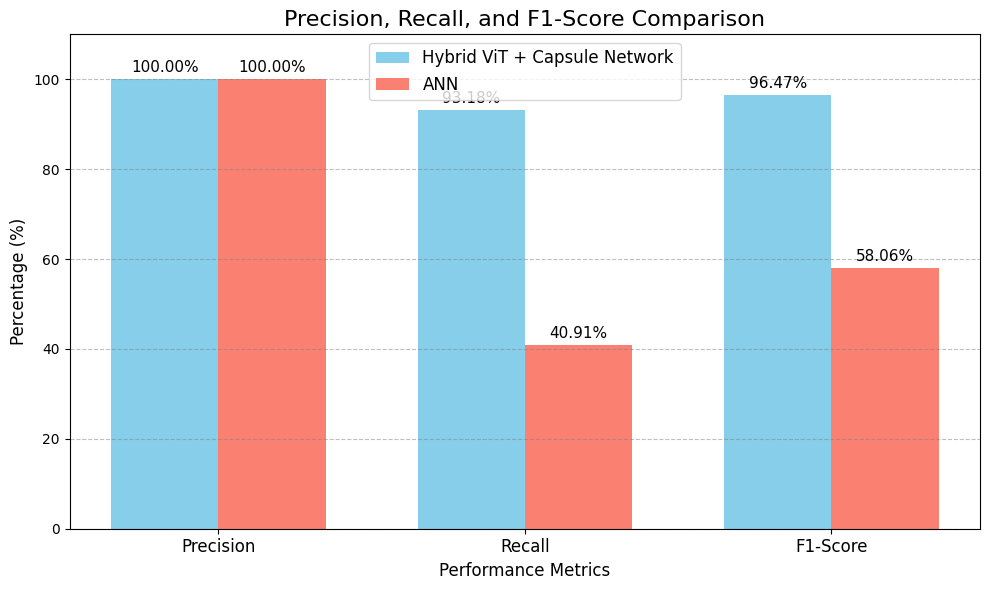

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Data
metrics = ['Precision', 'Recall', 'F1-Score']
hybrid_model = [100, 93.18, 96.47]
ann_model = [100, 40.91, 58.06]

# Positions of the bars on the x-axis
x = np.arange(len(metrics))  # [0, 1, 2]
bar_width = 0.35

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for Hybrid ViT + Capsule Network model
bars1 = ax.bar(x - bar_width/2, hybrid_model, bar_width, label='Hybrid ViT + Capsule Network', color='skyblue')

# Plot bars for ANN model
bars2 = ax.bar(x + bar_width/2, ann_model, bar_width, label='ANN', color='salmon')

# Labels and Title
ax.set_xlabel('Performance Metrics', fontsize=12)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Precision, Recall, and F1-Score Comparison', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)

# Y-axis limits
ax.set_ylim(0, 110)

# Add legend
ax.legend(fontsize=12)

# Annotate bars with their heights
def annotate_bars(bars, fmt="{:.2f}%"):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(fmt.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=11)

annotate_bars(bars1)
annotate_bars(bars2)

# Grid for better readability
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

# Tight layout for neatness
fig.tight_layout()

# Display the plot
plt.show()

# Save the plot as a PNG image (optional)
# plt.savefig('precision_recall_f1_comparison.png', dpi=300)
